Edit Applied Potential for MECSim input
=====


This script will read in the MECSim output and replace the potential with a user defined function. This can then be used as the input potential function ``EInput.txt``. To make MECSim use this input file the advanced ramp setting should be set to equal ``2``.

WARNING
----

The derivatives of the applied potential will not be as accurate as usual.

Usually MECSim knows the ramp and the ac signal in advance, which means that the time derivative is also known analytically. So there is no error at all in the time derivative. Some adjustments for iterating over large uncompensated resistor values perhaps, but this is a small effect.

In the case or reading in the potential from a file the derivative IS NOT known in advance. Neither does MECSim know the form of the function. So the derivative can not be determined analytically. At the moment it is approximated by

$$
    \frac{ d E_{app} }{dt} = \frac{\Delta E_{app} }{\Delta t}
$$

over a single timestep! This is very inaccurate in some cases, so... **USE AT OWN RISK**


Usage
=====

Here functions that define a square wave and single value over time are provided. New functions can be defined by the user and applied in the same way as these are to create custom made applied potentials.

In [1]:
# import required python packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Functions for reading files
----


In [2]:
# load MECSim output file - DigiPot header (e,i,t)
def ReadMECSimOut(filename):
    f = open(filename, 'r')
    # search for last line of header that is made by MECSim (always this line)
    for line in f:
        if line.strip() == "Post(ms):       0.000000E+00": break
    time = []
    eapp = []
    current = []
    for line in f:
        columns = line.split()
        eapp.append(float(columns[0]))
        current.append(float(columns[1]))
        time.append(float(columns[2]))
    return np.asfarray(eapp), np.asfarray(current), np.asfarray(time)  # e,i,t

# load MECSim output file (input order is also e,i,t)
def ReadMECSimFile(filename):
    f = open(filename, 'r')
    time = []
    eapp = []
    current = []
    for line in f:
        columns = line.split()
        eapp.append(float(columns[0]))
        current.append(float(columns[1]))
        time.append(float(columns[2]))
    return eapp, current, time    # e, i, t

# strip the header from MECSim output file (DigiPot header)
def StripHeader(filename):
    f = open(filename, 'r')
    header = []
    for line in f:
        header.append(line)
        if line.strip() == "Post(ms):       0.000000E+00": break
    return header

Function for writing files
----

In [3]:
def WriteMECSimOut(filename, header, e, i, t):
    f = open(filename, 'w')
    for j in range(len(header)):
        f.write(header[j])
    for j in range(len(t)):
        f.write('{0:13.6e}  {1:13.6e}  {2:13.6e}\n'.format(e[j], i[j], t[j]))
    return

Functions for generating new applied potential functions
----

In [4]:
# Emax first, then change to Emin etc (note Emax can be < Emin depending on what user wants first)
def SquareWave(Emax, Emin, freq, e, t):
    emod = np.zeros(len(e))
    period = 1./freq
    iUseMax = True  # start using the 'max' value
    tLastChange = 0.0
    for i in range(len(t)):
        tdiff = t[i] - tLastChange
        if(tdiff>=period):
            iUseMax*=-1 # flip switch
            tLastChange = t[i]
        if(iUseMax==True):
            emod[i] = Emax
        else:
            emod[i] = Emin
    return emod

# set to a single value for all time
def SingleValue(Evalue, e):
    emod = np.zeros(len(e))
    emod[:] = Evalue
    return emod

Read voltage, current and time from MECSim output file
-----

This provides the template for the output file.

In [5]:
e_app, i_out, t_out = ReadMECSimOut('MECSimOutput_Pot.txt')

Modify applied voltage using one of the functions defined above
----

Example used here is a square wave from -0.5 to 0.5 V with a frequency of 1 Hz. It will use the same total time as the template MECSim output file read in the previous cell (in the figure it was 26.8 seconds).

Modify here with own functions if required.

In [6]:
e_mod = SquareWave(0.5, -0.5, 1., e_app, t_out)
#e_mod = SingleValue(e_app[0], e_app)

Output new file with modified applied voltage
-----

In [7]:
header = StripHeader('MECSimOutput_Pot.txt')
WriteMECSimOut('EInput.txt',header, e_mod, i_out, t_out)

Plot modified $E_{app}$ and original against time
----

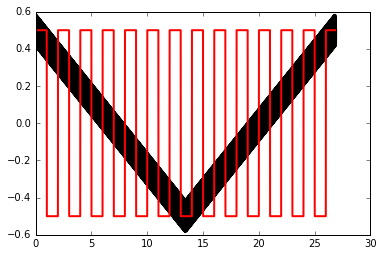

In [8]:
plt.plot(t_out, e_app, 'k', linewidth=4)
plt.plot(t_out, e_mod, 'r', linewidth=2)
plt.show()